# Kmeans cluster investigation
This NB contains the following analysis:

##### Clusters size
Present how many cells there are in clusters

##### Barcode documentation
Creates excel mapping barcodes to clusters

##### Cluster content
- Part1: 
looks at the expression levels of known markers (given cell-type) of specific clusters.
 looks for number of mye&lymph conflicts in specified cluster.
- Part2: compares expression levels across all genes between two specified clusters.

##### Diffrential expression of Immune/fibroblast markers
- given cell-type/markers print boxplot of distribution for all clusters

##### Clusters contaminated with fibroblast markers
- Part1: Loads cohort file and kmeans file (should be compatible!!!)
- Part2: shows amount of cells expressing fibroblast markers in cluster
- Part3: builds a DF for use_inferCNV_clustering_to_update_data.py

##### Finds markers of a given cluster
mediate marker definition. lower thresholds etc.

##### Immune cells fib exploration
The number of immune cells expressing each number of fibroblast markers

##### tSNE Investigation
if there is a cluster which you believe it should have been divided to two and you want to mannually divide it by the coordinates of tSNE and find markers for each part. This mainly a thing you do when the Heatmap looked as the markers corresponded to half of the cells in the cluster. 

In [32]:
# ------- SERVER EXTENSIONS ---------
lib =  r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/utilities/droplet_dataset'
lib2 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/utilities'
lib3 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/data_analysis'
lib4 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy'
lib5 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/scripts'
lib6 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/scripts/preprocess_data'
import sys
sys.path.append(lib)
sys.path.append(lib2)
sys.path.append(lib3)
sys.path.append(lib4)
sys.path.append(lib5)
sys.path.append(lib6)
from classifying_cell_types import *
from utilities.general_helpers import *
# ------- SERVER EXTENSIONS ---------
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.manifold import TSNE
from utilities.ML_environment import find_marker_genes_in_cluster
import pickle
# from Bio.Cluster import kcluster
# from Bio.Cluster import kcluster
# import pyclustering
from utilities.ML_environment import find_marker_genes_in_cluster
import os
import numpy as np
import yaml
from os.path import join
import os
import pandas
from collections import Counter
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import sys
import seaborn as sns
# import statsmodels as sm
import scipy.stats as stats
from scipy.stats import rankdata
from sklearn.manifold import TSNE
import pickle
import numpy as np
from utilities.general_helpers import flatten_list
# from utilities.ML_environment import find_marker_genes_in_cluster
from shutil import copyfile
import matplotlib.pyplot as plt
from utilities.clustering_tools import find_marker_genes_in_cluster

# Clusters size

- Present how many cells there are in clusters

In [41]:
KMEANS_PATH = fr'/storage/md_keren/shitay/outputs/clustering/kmeans/26.6.21/row_kmeans'
KMEANS_FILE_NAME = f'kmeans_immune_cells_4k_genes_k' # ENDS WITH _i.pkl for i in range(2, 15)

clusters_size = []
first_k=2
last_k=15


for K in range(first_k, last_k+1):
    file_full_path = join(KMEANS_PATH, KMEANS_FILE_NAME+f'_{K}.pkl')
    kmeans_file = pickle.load(open(file_full_path, 'rb'))
    clusters_indices = kmeans_file['clusters']


    clusters_size.append([len(cluster) for idx, cluster in enumerate(clusters_indices)])
df = pd.DataFrame(clusters_size)
df.index = [f'K={v}' for v in range(first_k, last_k+1)]
df = df.T
df.index = [v for v in range(1, last_k+1)]

# df

In [43]:
df.to_excel(f'/storage/md_keren/shitay/outputs/clustering/kmeans/26.6.21/clusters_size.xlsx')

# Barcode documentation

Creates excel mapping barcodes to clusters

In [25]:
FILTERED_CELLS_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/cohort/normalized/6.21/cohort_normalized_26.6.21.pkl'
KMEANS_ROW_CLUSTERS_PATH = r'/storage/md_keren/shitay/outputs/clustering/kmeans/26.6.21/row_kmeans'
KMEANS_FILE_NAME = r'kmeans_immune_cells_4k_genes'  # excluding the suffix: '_k_num.pkl'

In [26]:
print(f'Loading cohort file:\n{FILTERED_CELLS_PATH}')
cohort = pickle.load(open(FILTERED_CELLS_PATH, 'rb'))
filtered_cells = cohort.filter_cells_by_property('is_immune', True)

Loading cohort file:
/storage/md_keren/shitay/Data/droplet_seq/cohort/normalized/6.21/cohort_normalized_26.6.21.pkl


In [27]:
K = 15
kmeans_file_path = join(KMEANS_ROW_CLUSTERS_PATH, KMEANS_FILE_NAME + f'_k_{K}.pkl')
print(f'Loading kmeans file:\n{kmeans_file_path}')
clusters = pickle.load(open(kmeans_file_path, 'rb'))['clusters']

Loading kmeans file:
/storage/md_keren/shitay/outputs/clustering/kmeans/26.6.21/row_kmeans/kmeans_immune_cells_4k_genes_k_15.pkl


In [28]:
clusters_cells = [filtered_cells[cluster_indices] for cluster_indices in clusters]

In [29]:
# [cls.number_of_cells for cls in clusters_cells]

In [30]:
df = pd.DataFrame(columns=['Sample', 'Barcode', 'Cluster'])

# [cls.number_of_cells for cls in clusters_cells]
cluster_idx = 1
for idx, cls in enumerate(clusters_cells):  
    if cls.number_of_cells > 30:
        df = df.append(pd.DataFrame(transpose_list([cls.samples, cls.barcodes, [cluster_idx]*cls.number_of_cells]), columns=df.columns))
        cluster_idx += 1
    else:
        print(f'cluster {idx+1} contains {cls.number_of_cells} cells (less than 30 cells) and therefore excluded from DF')
df = df.reset_index()

cluster 2 contains 2 cells (less than 30 cells) and therefore excluded from DF
cluster 6 contains 3 cells (less than 30 cells) and therefore excluded from DF
cluster 9 contains 1 cells (less than 30 cells) and therefore excluded from DF
cluster 13 contains 1 cells (less than 30 cells) and therefore excluded from DF


In [31]:
df.to_csv(r'/storage/md_keren/shitay/garbage/immune_kmeans_26.6.21_clusters_mapping.csv', index=False)

# Cluster content

###### (MUST) Data path (uploading):

In [2]:
print("Important Note: you are uploading cohort file and kmeans file. Make sure they are compatible")
KMEANS_PATH = fr'/storage/md_keren/shitay/outputs/clustering/kmeans/row_kmeans'

filtered_cells_path = r'/storage/md_keren/shitay/Data/droplet_seq/cohort/normalized/6.21/cohort_normalized_10.6.21.pkl'
cohort = pickle.load(open(filtered_cells_path, 'rb'))
filtered_cells = cohort[cohort.cells_information.getattr('is_immune')]

# empty_barcodes_path = r'/storage/md_keren/shitay/outputs/CellBender/empty_droplets_barcodes.csv'
# empty_barcodes_df = pd.read_csv(empty_barcodes_path)

Important Note: you are uploading cohort file and kmeans file. Make sure they are compatible


Extracts wanted cluster:

In [4]:
# Extract kmeans solution (K) and cluster (cls_idx) 
K = 11
cls_idx = 7
path = join(KMEANS_PATH, f'kmeans_immune_cells_var0.315_k_{K}.pkl')
kmeans = pickle.load(open(path, 'rb'))
print(f'K = {K}')
print(f'cluster idx: {cls_idx}')

cluster_cells = filtered_cells[kmeans['clusters'][cls_idx-1]]

K = 11
cluster idx: 7


Prints how many cell having a mye & lymph conflict:

In [5]:
mye = np.array([cluster_cells.cells_information.getattr('is_myeloid')])
lym = np.array([cluster_cells.cells_information.getattr('is_lymphoid')])
# np.concatenate((mye, lym), axis=0)
print(f'number of cell in cluster: {cluster_cells.number_of_cells}')
print(f'number of mye&lymph-conflict cells: {np.sum(mye & lym )}')

number of cell in cluster: 7587
number of mye&lymph-conflict cells: 38


Prints cell-types in the given cluster that have been found during marker classification process:

In [6]:
print(f'Cell-types shown in cluster {cls_idx}, K={K}:')
sorted(Counter(flatten_list(cluster_cells.cells_information.getattr('cell_type_list'))).items(), key=lambda x: x[1], reverse=True)

Cell-types shown in cluster 7, K=11:


[('Immune_general', 3727),
 ('Neutrophils', 3411),
 ('Granolocytes', 1952),
 ('B cells', 290),
 ('T cells', 237),
 ('CD8 Cytotoxic T cells', 82),
 ('Exhausted T cells', 66),
 ('myeloid cells_general_mature', 57),
 ('cDCs_dendritic_cells', 56),
 ('CD4 helper T cells', 41),
 ('NKT cells', 29),
 ('myeloid cells_general_immature', 17),
 ('pDCs', 15),
 ('Activated T cells', 14),
 ('Memory CD8 T cells', 11),
 ('Monocyte_mature', 9),
 ('Macrophage_mature', 7),
 ('Regulatory T cells', 7),
 ('Memory CD4 T cells', 6),
 ('NK cells', 4),
 ('Regulatory CD4 T cells', 3),
 ('Memory T cells', 2),
 ('Monocyte_immature', 1)]

Takes neutrophils markers and show expression levels of cells in cluster:

In [8]:
print('take neutrophils markers and show expression levels of cells in cluster')
neutrophils_markers = 'FUT4;FCGR3B;CXCR1;CXCR2;G0S2;CSF3R;FCGR3A'
neutrophils_markers = neutrophils_markers.split(';')
gene_idx = [cluster_cells.gene_names.index(marker) for marker in neutrophils_markers if marker in cluster_cells.gene_names]
neu_cells = cluster_cells[['Neutrophils' in vv for vv in cluster_cells.cells_information.getattr('cell_type_list')]]

ll= list(zip(neu_cells.samples,neu_cells.barcodes))#
values = [list(map(list, zip(neu_cells.samples,neu_cells.barcodes)))[i] + neu_cells.counts[:, gene_idx].round(2).tolist()[i] for i in range(len(ll))]
columns = ['Sample', 'Barcode']+[neu_cells.gene_names[idx] for idx in gene_idx]
df = pd.DataFrame(values, columns=columns).sort_values(['Sample', 'Barcode'])
df.head(2)

take neutrophils markers and show expression levels of cells in cluster


,Sample,Barcode,FUT4,FCGR3B,CXCR1,CXCR2,G0S2,CSF3R,FCGR3A
0,M100,TCTATTGGTAAGTGTA-1,0.92,0.0,0.0,0.0,0.0,0.0,0.0
1,M101,AAACCTGAGCGTAATA-1,1.19,0.0,0.0,0.0,0.0,0.0,0.0


Remove comment if you want to remove the DF:

In [9]:
# df.to_csv(r'/storage/md_keren/shitay/garbage/cluster9_k11.csv', index=False)

Shows the number of neutrophil markers, the identified neutrophil cells express:

In [10]:
print('Number of neutrophil markers, the identified neutrophil cells express (cluster #9 in k=11):')
dic = sorted(dict(Counter(np.sum(neu_cells.counts[:, gene_idx]!=0, axis=1))).items())
{f'n_cells express {x} markers': y for x,y in dic}

Number of neutrophil markers, the identified neutrophil cells express (cluster #9 in k=11):


{'n_cells express 1 markers': 3257,
 'n_cells express 2 markers': 144,
 'n_cells express 3 markers': 6,
 'n_cells express 5 markers': 3,
 'n_cells express 6 markers': 1}

Shoes neutrophil markers expression distribution:

Neutrophil markers expression distribution:


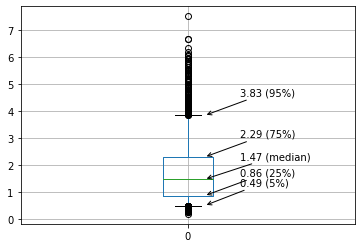

In [11]:
print('Neutrophil markers expression distribution:')
arr = neu_cells.counts[:, gene_idx].flatten()
arr = arr[arr!=0]
annotate_boxplot(pd.DataFrame(arr).boxplot(whis=[5, 95], return_type='dict'), arr)

###### 2. Conducts a comparison across all genes of 2 specified clusters: 

In [4]:
# Extract kmeans solution (K) and cluster (cls_idx) 
K_solution_1 = 11
cluster_idx_1 = 7

K_solution_2 = 11
cluster_idx_2 = 9

print(f'Conducting a comparison:')
path = join(KMEANS_PATH, f'kmeans_immune_cells_var0.315_k_{K_solution_1}.pkl')
kmeans = pickle.load(open(path, 'rb'))
cluster_1_cells = filtered_cells[kmeans['clusters'][cluster_idx_1-1]]
print('First cluster:')
print(f'K = {K_solution_1}')
print(f'cluster_idx: {cluster_idx_1}')
print(f'Number of cells: {cluster_1_cells.number_of_cells}')


path = join(KMEANS_PATH, f'kmeans_immune_cells_var0.315_k_{K_solution_2}.pkl')
kmeans = pickle.load(open(path, 'rb'))
cluster_2_cells = filtered_cells[kmeans['clusters'][cluster_idx_2-1]]
print('\nSecond cluster:')
print(f'K = {K_solution_2}')
print(f'cluster_idx: {cluster_idx_2}')
print(f'Number of cells: {cluster_2_cells.number_of_cells}')

Conducting a comparison:
First cluster:
K = 11
cluster_idx: 7
Number of cells: 7587

Second cluster:
K = 11
cluster_idx: 9
Number of cells: 2883


In [5]:
# get subset of the cluster

print(f'Number of cells in cluster {cluster_1_cells.number_of_cells}')
neutrophils_markers = 'FUT4;FCGR3B;CXCR1;CXCR2;G0S2;CSF3R;FCGR3A'
neutrophils_markers = neutrophils_markers.split(';')
gene_idx = [cluster_1_cells.gene_names.index(marker) for marker in neutrophils_markers if marker in cluster_1_cells.gene_names]
sub_cluster_1_cells = cluster_1_cells[['Neutrophils' in vv for vv in cluster_1_cells.cells_information.getattr('cell_type_list')]]
print(f'Number of cells in sub-cluster {sub_cluster_1_cells.number_of_cells}')
# Counter(cluster_1_cells.samples)

Number of cells in cluster 7587
Number of cells in sub-cluster 3411


Remove comment if you want to see counter of samples in given cluster

In [19]:
# Counter(cluster_1_cells.samples)
# print(cluster_1_cells.number_of_cells)


Runs find_marker_genes_in_cluster using log_FC_threshold=-1000 means that there will be no filter of the direction of the marker, 
we will get highly expressed genes of cluster1 compared to cluster2 and vise versa.

In [5]:
comparison_res = find_marker_genes_in_cluster(cluster_1_cells, cluster_2_cells, log_FC_threshold=-1000, pval_threshold=0.05)

Saves results

In [18]:
comparison_res = comparison_res.rename(columns={"contaminated - mean_expression": "contaminated cells - mean_expression",
                        "cluster 9": "cluster 9 - mean_expression"})
# comparison_res.to_csv(r'/storage/md_keren/shitay/garbage/k11_gene_comparison_with_contaminated.csv', index=False)

In [20]:
comparison_res.drop(columns=['n_expressing_cells__cls1 > n_expressing_cells__cls2']).to_csv(r'/storage/md_keren/shitay/garbage/k11_gene_comparison_with_contaminated.csv', index=False)

In [25]:
comparison_res[['features', 'gene names', 'corected_pval', 'log_FC', 'contaminated cells - mean_expression',
       'cluster 9 - mean_expression']].to_csv(r'/storage/md_keren/shitay/garbage/k11_gene_comparison_with_contaminated.csv', index=False)

# Diffrential expression of Immune/fibroblast markers 
* given cell-type/markers print boxplot of distribution of all clusters

In [51]:
FILTERED_CELLS_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/cohort/normalized/6.21/cohort_normalized_10.6.21.pkl'
KMEANS_ROW_CLUSTERS_PATH = r'/storage/md_keren/shitay/outputs/clustering/kmeans/24.5.21/row_kmeans'
KMEANS_FILE_NAME = r'kmeans_immune_cells_4k_genes'  # excluding the suffix: '_k_num.pkl'

#### Loads cohort file

In [52]:
print(f'Loading cohort file:\n{FILTERED_CELLS_PATH}')
cohort = pickle.load(open(FILTERED_CELLS_PATH, 'rb'))
filtered_cells = cohort.filter_cells_by_property('is_immune', True)

Loading cohort file:
/storage/md_keren/shitay/Data/droplet_seq/cohort/normalized/6.21/cohort_normalized_10.6.21.pkl


#### Loads kmeans file. Should be compatible with cohort file

In [53]:
K = 7
kmeans_file_path = join(KMEANS_ROW_CLUSTERS_PATH, KMEANS_FILE_NAME + f'_k_{K}.pkl')
print(f'Loading kmeans file:\n{kmeans_file_path}')
clusters = pickle.load(open(kmeans_file_path, 'rb'))['clusters']

Loading kmeans file:
/storage/md_keren/shitay/outputs/clustering/kmeans/24.5.21/row_kmeans/kmeans_immune_cells_4k_genes_k_7.pkl


#### split clusters and present the number of cells in each of them

In [54]:
clusters_cells = [filtered_cells[indices] for indices in clusters]
print([(idx+1, v.number_of_cells) for idx, v in enumerate(clusters_cells)])

[(1, 14783), (2, 5931), (3, 9415), (4, 12368), (5, 16035), (6, 12280), (7, 12849)]


#### Loads markers of cell-types from table
immune from excel and tumor and stromal as we defined without a file

In [55]:
MARKERS_PATH = r'/storage/md_keren/shitay/Data/tables/ImmuneCellsMarkersUpdated_12.11.20.xlsx'
MHC2_GENES = ['HLA-DMA',  'HLA-DMB',  'HLA-DOA',  'HLA-DOB',
                      'HLA-DPA1',  'HLA-DPB1',  'HLA-DQA1',  'HLA-DQB1',
                      'HLA-DQB2',  'HLA-DRA',  'HLA-DRB1',  'HLA-DRB5']
def replace_MHCII_genes(gene):
    if gene=='MHCII':
        return MHC2_GENES
    else:
        return gene
    
xls = pd.ExcelFile(MARKERS_PATH)
positive_markers_df = pd.read_excel(xls, 'and_or')
negative_markers_df = pd.read_excel(xls, 'none')
positive_markers_table = builds_cell_type_markers_table(positive_markers_df)
negative_markers_table = builds_cell_type_markers_table(negative_markers_df)
cell_types_markers_mapping = {k: [vv.split(';') for vv in v] for k,v in positive_markers_table.items()}
cell_types_markers_mapping = {k: flatten_list(v) for k,v in cell_types_markers_mapping.items()}
cell_types_markers_mapping = {k: [replace_MHCII_genes(gene) for gene in v] for k,v in cell_types_markers_mapping.items()}
cell_types_markers_mapping['tumor'] = ['MLANA', 'PMEL', 'TYR', 'MITF', 'AXL']
cell_types_markers_mapping['stromal'] = [g for g in filtered_cells.gene_names if g.startswith('COL1') or g.startswith('COL2') or g.startswith('KRT')]

#### Specify cell-types

In [56]:
print(f'Select cell-types from the list below:\n{list(cell_types_markers_mapping.keys())}')

Select cell-types from the list below:
['T cells', 'CD4 helper T cells', 'CD8 Cytotoxic T cells', 'Regulatory T cells', 'Regulatory CD4 T cells', 'Regulatory CD8 T cells', 'Regulatory CD4_CD8 T cells', 'NKT cells', 'NK cells', 'B cells', 'Activated T cells', 'Senescence T cells', 'Terminal effector', 'Exhausted T cells', 'Stem_like T cells', 'Memory T cells', 'Memory CD4 T cells', 'Memory CD8 T cells', 'Memory CD4_CD8 T cells', 'Macrophage_immature', 'Macrophage_mature', 'Monocyte_immature', 'Monocyte_mature', 'cDCs_dendritic_cells', 'pDCs', 'myeloid cells_general_immature', 'myeloid cells_general_mature', 'Neutrophils', 'Granolocytes', 'Immune_general', 'tumor', 'stromal']


In [57]:
LYMPHOID = ['T cells', 'CD4 helper T cells', 'CD8 Cytotoxic T cells', 'Regulatory T cells', 'Regulatory CD4 T cells', 'Regulatory CD8 T cells', 'Regulatory CD4_CD8 T cells', 'NKT cells', 'NK cells', 'B cells', 'Activated T cells', 'Senescence T cells', 'Terminal effector', 'Exhausted T cells', 'Stem_like T cells', 'Memory T cells', 'Memory CD4 T cells', 'Memory CD8 T cells', 'Memory CD4_CD8 T cells']
MYELOID = ['Macrophage_immature', 'Macrophage_mature', 'Monocyte_immature', 'Monocyte_mature', 'cDCs_dendritic_cells', 'pDCs', 'myeloid cells_general_immature', 'myeloid cells_general_mature', 'Neutrophils', 'Granolocytes']

# specify here
# cell_types = MYELOID# ['T cells', 'CD8 Cytotoxic T cells', 'Macrophage_mature']
cell_types =['stromal']

#### Calculates expression of the markers of these cell-types

In [58]:
df = pd.DataFrame(columns=['expression', 'cluster_idx', 'cell_type', 'marker'])
supervised_non_duplication_markers = []
for cell_type in cell_types:
    for marker_name in cell_types_markers_mapping[cell_type]:
        if marker_name in supervised_non_duplication_markers:
            continue
        else:
            supervised_non_duplication_markers.append(marker_name)
        for i in range(len(clusters_cells)):
            cluster_cells = clusters_cells[i]
            if not marker_name in cluster_cells.gene_names:
                continue
            marker_index = cluster_cells.gene_names.index(marker_name)
            cluster_cells.counts[:, marker_index]
            df = df.append(pd.DataFrame(np.concatenate([[cluster_cells.counts[:, marker_index]],
                                                        [np.ones(cluster_cells.number_of_cells).astype(int)*(i+1)],
                                                       [[cell_type]*cluster_cells.number_of_cells],
                                                       [[marker_name]*cluster_cells.number_of_cells]], axis=0).T, 
                                        columns=df.columns))
        
df['cluster_idx'] = df['cluster_idx'].astype('int32')
df['expression'] = df['expression'].astype(np.float32)

#### Present marker expression boxplots

In [59]:
print(f'If this value: {int(len(list(df["marker"].unique())))} is bigger than 12, split the next plot into piceses of 12 as writen')

If this value: 176 is bigger than 12, split the next plot into piceses of 12 as writen


<Figure size 1152x720 with 0 Axes>

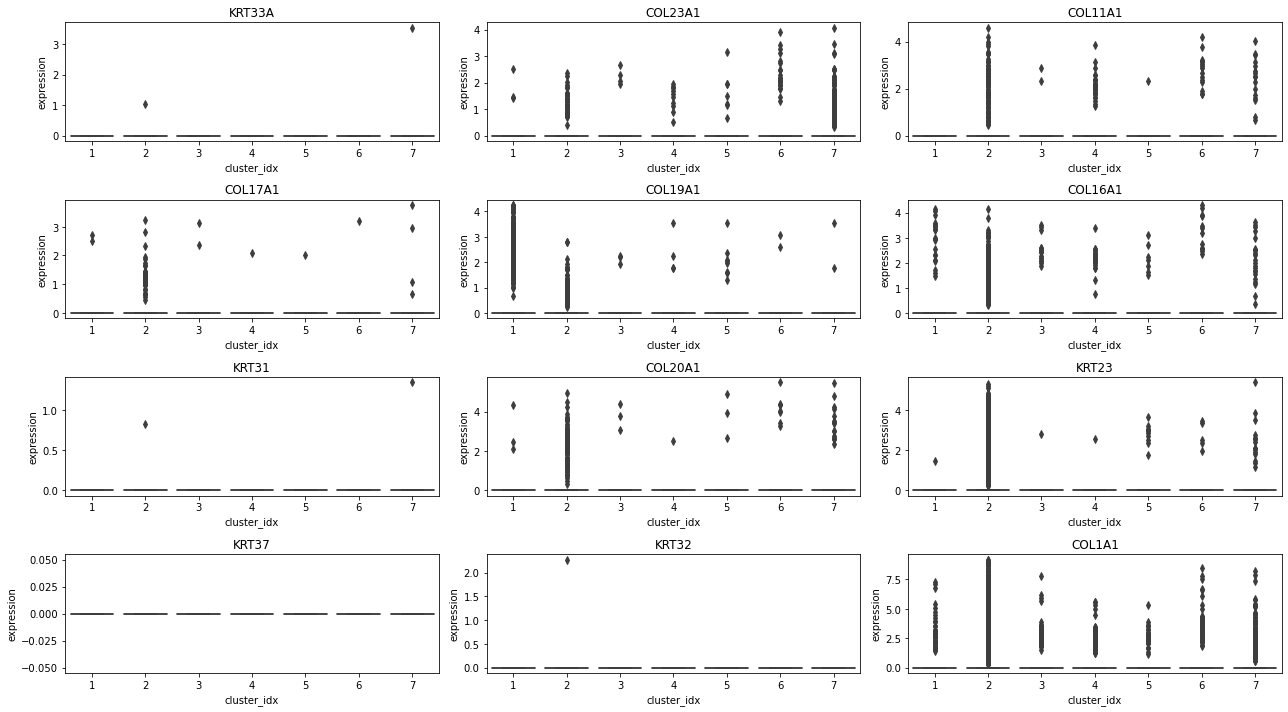

In [100]:
markers_list = list(df['marker'].unique())
# markers_list = list(df['marker'].unique())[int(len(list(df['marker'].unique()))/2):] ## split into 2 when there are many markers (more than 12)
markers_list = list(df['marker'].unique())[:12] ## Takes first 12 markers (more than 12)

plt.figure(figsize=(16,10))
# plt.figure(figsize=(16,56))
fig, axes = plt.subplots(int(np.ceil(len(markers_list)/3)), 3, figsize=(18, 10))
axes = axes.ravel()
axes_indices = [(x,y) for x in range(int(np.ceil(len(markers_list)/3))) for y in range(3)]

for idx, marker_name in enumerate(markers_list):
    
    if len(axes.shape)>1:
        ax = axes[axes_indices[idx][0], axes_indices[idx][1]]
    else:
        ax = axes[idx]
    
    marker_df = df[df['marker']==marker_name]
    g = sns.boxplot(ax=ax, x="cluster_idx", y="expression", data=marker_df);
    ax.set_title(marker_name)
fig.tight_layout()

if len(markers_list)%3>0:
    for i in range(3-len(markers_list)%3, 0, -1):
        axes[-i].remove()

In [93]:
fig.savefig(f'/storage/md_keren/shitay/garbage/stromal_marker_expression_distributions_p15.jpg')

# Clusters contaminated with fibroblast markers
* Part1: Loads cohort file and kmeans file (should be compatible!!!)
* Part2: shows amount of cells expressing fibroblast markers in cluster
* Part3: builds a DF for use_inferCNV_clustering_to_update_data.py

##### Part1: Loads cohort file and kmeans file (should be compatible!!!)

In [7]:
FILTERED_CELLS_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/cohort/normalized/6.21/cohort_normalized_10.6.21.pkl'
KMEANS_ROW_CLUSTERS_PATH = r'/storage/md_keren/shitay/outputs/clustering/kmeans/24.5.21/row_kmeans'
KMEANS_FILE_NAME = r'kmeans_immune_cells_4k_genes'  # excluding the suffix: '_k_num.pkl'


In [9]:
K = 15
print(f'Loading cohort file:\n{FILTERED_CELLS_PATH}')
cohort = pickle.load(open(FILTERED_CELLS_PATH, 'rb'))
filtered_cells = cohort.filter_cells_by_property('is_immune', True)

kmeans_file_path = join(KMEANS_ROW_CLUSTERS_PATH, KMEANS_FILE_NAME + f'_k_{K}.pkl')
print(f'Loading kmeans file:\n{kmeans_file_path}')
clusters = pickle.load(open(kmeans_file_path, 'rb'))['clusters']

# markers = find_markers_in_clusters(filtered_cells, clusters)

Loading cohort file:
/storage/md_keren/shitay/Data/droplet_seq/cohort/normalized/6.21/cohort_normalized_10.6.21.pkl
Loading kmeans file:
/storage/md_keren/shitay/outputs/clustering/kmeans/24.5.21/row_kmeans/kmeans_immune_cells_4k_genes_k_15.pkl


fib markers start with 'COL1' or 'COL2' or KRT.
Lets find them and their location in the sequencing:

##### Part2: shows amount of cells expressing fibroblast markers in cluster

In [10]:
fib_genes = np.array([[idx, g] for idx, g in enumerate(filtered_cells.gene_names) if g.startswith('COL1') or g.startswith('COL2') or (g.startswith('KRT') and g[3]<='9' and g[3]>='0')])

In [57]:
cls_index = 12
print(f'The number of cells in cluster {cls_index} expressing each number of fibroblast markers')
cluster_cells_indices = clusters[cls_index-1]
cluster_cells = filtered_cells[cluster_cells_indices]

amount_expressing_fib_dic = sort_dic(dict(Counter(np.sum(cluster_cells.counts[:, fib_genes[:,0].astype(int)]>1, axis=1))))
print(f'number of cells expressing exactly:')
print(amount_expressing_fib_dic)

print()
max_markers = np.max(list(amount_expressing_fib_dic.keys()))
more_or_equal_dic = {i:0 for i in range(max_markers+1)}
for n_fib_genes, amount in amount_expressing_fib_dic.items():
    for i in range(n_fib_genes+1):
        more_or_equal_dic[i] += amount
for i in range(max_markers+1):
    print(f'{more_or_equal_dic[i]} ({round(more_or_equal_dic[i]/cluster_cells.number_of_cells*100, 2)}%) cells in cluster express {i} or more fib markers')

The number of cells in cluster 12 expressing each number of fibroblast markers
number of cells expressing exactly:
{0: 401, 1: 901, 2: 822, 3: 736, 4: 419, 5: 296, 6: 345, 7: 143, 8: 53, 9: 31, 10: 9, 11: 3, 14: 1, 15: 1}

4161 (100.0%) cells in cluster express 0 or more fib markers
3760 (90.36%) cells in cluster express 1 or more fib markers
2859 (68.71%) cells in cluster express 2 or more fib markers
2037 (48.95%) cells in cluster express 3 or more fib markers
1301 (31.27%) cells in cluster express 4 or more fib markers
882 (21.2%) cells in cluster express 5 or more fib markers
586 (14.08%) cells in cluster express 6 or more fib markers
241 (5.79%) cells in cluster express 7 or more fib markers
98 (2.36%) cells in cluster express 8 or more fib markers
45 (1.08%) cells in cluster express 9 or more fib markers
14 (0.34%) cells in cluster express 10 or more fib markers
5 (0.12%) cells in cluster express 11 or more fib markers
2 (0.05%) cells in cluster express 12 or more fib markers
2 (

##### Part3: builds a DF for use_inferCNV_clustering_to_update_data.py

In [59]:
df = pd.DataFrame(np.array([cluster_cells.samples, cluster_cells.barcodes]).T, columns=['sample', 'barcode'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4161 entries, 0 to 4160
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   sample   4161 non-null   object
 1   barcode  4161 non-null   object
dtypes: object(2)
memory usage: 65.1+ KB


In [60]:
save_path = f'/storage/md_keren/shitay/Data/tables/kmeans_conclusion_tables/epithelial_contaminated_cells_kmeans24.5.21_k15_cluster12.csv'
df.to_csv(save_path)

# Finds markers of a given cluster
mediate marker definition. lower thresholds etc.

In [4]:
FILTERED_CELLS_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/cohort/normalized/6.21/cohort_normalized_26.6.21.pkl'
KMEANS_ROW_CLUSTERS_PATH = r'/storage/md_keren/shitay/outputs/clustering/kmeans/26.6.21/row_kmeans'
KMEANS_FILE_NAME = r'kmeans_immune_cells_4k_genes'  # excluding the suffix: '_k_num.pkl'

In [5]:
K = 15
print(f'Loading cohort file:\n{FILTERED_CELLS_PATH}')
cohort = pickle.load(open(FILTERED_CELLS_PATH, 'rb'))
filtered_cells = cohort.filter_cells_by_property('is_immune', True)

kmeans_file_path = join(KMEANS_ROW_CLUSTERS_PATH, KMEANS_FILE_NAME + f'_k_{K}.pkl')
print(f'Loading kmeans file:\n{kmeans_file_path}')
clusters = pickle.load(open(kmeans_file_path, 'rb'))['clusters']

# markers = find_markers_in_clusters(filtered_cells, clusters)

Loading cohort file:
/storage/md_keren/shitay/Data/droplet_seq/cohort/normalized/6.21/cohort_normalized_26.6.21.pkl
Loading kmeans file:
/storage/md_keren/shitay/outputs/clustering/kmeans/26.6.21/row_kmeans/kmeans_immune_cells_4k_genes_k_15.pkl


Conducts a statictical test to find marker of a given cluster_idx

In [6]:
cls_index = 15
cluster_cells_indices = clusters[cls_index-1]
other_clusters_indices = flatten_list([[ind for ind in cluster_indices] for cluster_idx, cluster_indices in enumerate(clusters) if cluster_idx!=cls_index-1])

cluster_cells = filtered_cells[cluster_cells_indices]
other_clusters_cells = filtered_cells[other_clusters_indices]
print(f'The number of cells in cluster {cls_index} is {cluster_cells.number_of_cells}')

The number of cells in cluster 15 is 5345


In [7]:
# other_clusters_cells.number_of_cells + cluster_cells.number_of_cells - filtered_cells.number_of_cells # sanity check
# df = find_marker_genes_in_cluster(cluster_cells, other_clusters_cells, log_FC_threshold = 0.25, pval_threshold=0.05, min_pct=0.1, min_diff_pct=0.1)

df2 = find_marker_genes_in_cluster(cluster_cells, other_clusters_cells, log_FC_threshold = 0.25, pval_threshold=0.05, min_pct=0.1, min_diff_pct=0.06)
df2.sort_values('%expressing_diff', ascending=False, ignore_index=True)

In [16]:
df3 = find_marker_genes_in_cluster(cluster_cells, other_clusters_cells, log_FC_threshold = 0.25, pval_threshold=0.05, min_pct=0.06, min_diff_pct=0.06)

In [17]:
df3.shape

(31, 11)

# Immune cells fib exploration

The number of immune cells expressing each number of fibroblast markers

In [32]:
print(f'The number of cells expressing each number of fibroblast markers')
sort_dic(dict(Counter(np.sum(filtered_cells.counts[:, fib_genes[:,0].astype(int)]>0, axis=1))))

The number of cells expressing each number of fibroblast markers


{0: 54807,
 1: 23448,
 2: 2525,
 3: 897,
 4: 622,
 5: 432,
 6: 351,
 7: 273,
 8: 176,
 9: 83,
 10: 29,
 11: 4,
 12: 8,
 13: 3,
 14: 2,
 15: 1}

Now lets see if we set a threshold of the minimum number of fib markers, how many cells we would remove from the immune compartment

In [28]:
min_markers = 2
count = 0
dd = sort_dic(dict(Counter(np.sum(filtered_cells.counts[:, fib_genes[:,0].astype(int)]>0, axis=1))))
for k, v in dd.items():
    if k>=min_markers:
        count += v
print(count)

5406


Lets build a table showing for each fib marker how many cells expressing it.

In [29]:
df = pd.DataFrame(columns=['gene', 'number of cells expressing'])
sorted_fib_genes = sorted(fib_genes.tolist(), key=lambda x: x[1])
for marker in sorted_fib_genes:
#     print([marker[1], 0])
    count = sum(filtered_cells.counts[:, int(marker[0])]>0)    
    df = df.append(pd.DataFrame([[marker[1], count]], columns=df.columns))

In [62]:
# df = df.reset_index().drop(columns=['level_0', 'index'])
df.to_csv(r'/storage/md_keren/shitay/garbage/fib_genes_table.csv')

# tSNE Investigation

if there is a cluster which you believe it should have been divided to two and you want to mannually divide it by the coordinates of tSNE and find markers for each part. This mainly a thing you do when the Heatmap looked as the markers corresponded to half of the cells in the cluster.

In [33]:
IMMUNE_CELLS_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/cohort/normalized/6.21/immune_cells_26.6.21_4k_genes.pkl'
immune_cells = pickle.load(open(IMMUNE_CELLS_PATH, 'rb'))

In [34]:
# Reset params
# plt.rcParams["figure.figsize"] = 4, 3 #plt.rcParamsDefault["figure.figsize"]
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

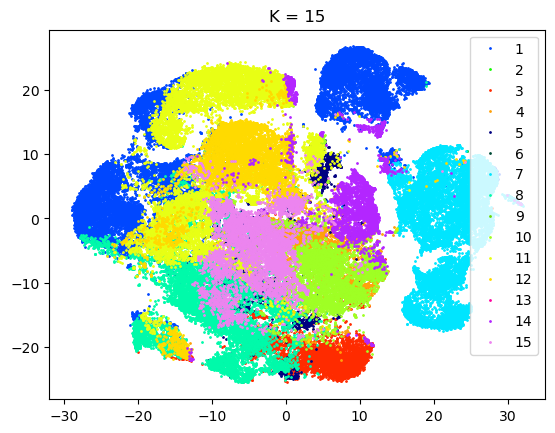

In [35]:
KMEANS_PATH = fr'/storage/md_keren/shitay/outputs/clustering/kmeans/26.6.21/row_kmeans/'
TSNE_PATH = fr'/storage/md_keren/shitay/outputs/TSNE/cohort_26.6.21/immune_cells_bhtsne_26.6.21.pkl'
KMEANS_FILE_NAME = f'kmeans_immune_cells_4k_genes_'
# OUTPUT = r'/storage/md_keren/shitay/liron_project/outputs/prints/immune_kmeans_k11.png'
k = 15

cells_embedded = pickle.load(open(TSNE_PATH, 'rb'))

colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired  
colors = np.array([colormap(i) for i in np.linspace(0, 0.9,15)])[[2, 5, 11, 10, 0, 1, 3, 4, 6, 7, 8, 9, 12, 13, 14]]

kmeans = pickle.load(open(join(KMEANS_PATH, KMEANS_FILE_NAME+f'k_{k}.pkl'), 'rb'))
# num_of_cells = sum([len(cl) for cl in kmeans['clusters']])

for cluster_idx, cluster_list in enumerate(kmeans['clusters']):
    Xi = cells_embedded[cluster_list, 0]
    Yi = cells_embedded[cluster_list, 1]
    plt.plot(Xi, Yi, 'ro', color=colors[cluster_idx], label=cluster_idx+1, markersize=1)

    plt.legend()
plt.title(f"K = {k}");
plt.show()

# plt.savefig(OUTPUT)

In [36]:
len(kmeans['clusters'][0])

15181

In [37]:
cluster_1 = kmeans['clusters'][0]
Xi = cells_embedded[cluster_1, 0]
Yi = cells_embedded[cluster_1, 1]

In [38]:
sum(Xi < -5)

8676

In [39]:
left_side_indices = np.array(cluster_1)[Xi < -5]
left_side_other_indices = [i for i in range(immune_cells.number_of_cells) if not i in left_side_indices]

right_side_indices = np.array(cluster_1)[Xi >= -5]
right_side_other_indices = [i for i in range(immune_cells.number_of_cells) if not i in right_side_indices]

In [40]:
left_cluster = immune_cells[left_side_indices]
left_complete = immune_cells[left_side_other_indices]

right_cluster = immune_cells[right_side_indices]
right_complete = immune_cells[right_side_other_indices]

In [15]:
left_markers_df = find_marker_genes_in_cluster(left_cluster, left_complete, 
                                                 log_FC_threshold = 0.25, 
                                                 pval_threshold=0.05,
                                                 min_pct=0.1, 
                                                 min_diff_pct=0.1)

In [17]:
right_markers_df = find_marker_genes_in_cluster(right_cluster, right_complete, 
                                                 log_FC_threshold = 0.25, 
                                                 pval_threshold=0.05,
                                                 min_pct=0.1, 
                                                 min_diff_pct=0.1)

In [24]:
pd.set_option('display.max_rows', 10)
left_markers_df.to_csv(r'/storage/md_keren/shitay/garbage/left.csv')

In [23]:
right_markers_df.to_csv(r'/storage/md_keren/shitay/garbage/right.csv')

# Debug

In [18]:
# sorted_fib_genes
# fib_genes

In [6]:
cluster_1_cells.number_of_cells
res = cluster_1_cells.get_subset_by_identifiers(sub_cluster_1_cells.samples, sub_cluster_1_cells.barcodes)

In [24]:
df = pd.DataFrame(np.array([sub_cluster_1_cells.samples, sub_cluster_1_cells.barcodes]).T, columns=['sample', 'barcode'])

path =r'/storage/md_keren/shitay/Data/tables/stroma_contaminated_cells_kmeans_k11_cluster7_expressing_neut.csv'
df.to_csv(path, index=False)

In [12]:
mapping = list(zip(sub_cluster_1_cells.samples, sub_cluster_1_cells.barcodes))

In [17]:
# mapping.index(mapping[200])


In [14]:
# maps = list(zip(cluster_1_cells.samples, cluster_1_cells.barcodes))
# dic_map = {vv: [] for vv in set(cluster_1_cells.samples)}
# dic_map
# for sample_id, barcode in maps:
#     dic_map[sample_id].append(barcode)
# dic_map

In [15]:
# barcode_idxs = []
# print([(k, len(vv)) for k,vv in dic_map.items()])
# for sample_id in sorted(dic_map.keys())[:4]:
#     print(sample_id)
#     def myfunc(n):
#         if sample_id == n[0]:
#             return n[1]
#         return None
# #     barcode_list = [c_barcode for c_sample_id, c_barcode zip(cluster_1_cells.samples, cluster_1_cells.barcodes)]
#     barcode_mask_list = list(map(myfunc, zip(cluster_1_cells.samples, cluster_1_cells.barcodes)))
#     barcodes_idx = [barcode_mask_list.index(barcode) for barcode in barcode_mask_list]
#     barcode_idxs += barcodes_idx
#     print(barcode_mask_list)

In [16]:
# def myfunc(n):
#   return len(n)

# list(map(myfunc, ('apple', 'banana', 'cherry')) )